In [353]:
import numpy as np
from scipy import stats
from numpy import nan
import pandas as pd
import s3fs
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_precision_recall_curve, plot_roc_curve
import statistics
from matplotlib import pyplot as plt
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
import pickle


In [3]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [5]:
conn = sf_connection()

### Let's read in the features we created

In [6]:
feature_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/score/yes_ecomm.parquet'

In [7]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

### Now we read in the label data

In [8]:
label_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/discount_lables.csv'

In [9]:
label_table = pd.read_csv(label_path, header=0)

In [10]:
len(feature_table.drop_duplicates('INDV_ID')), len(label_table.drop_duplicates('INDV_ID'))

(22529095, 22327757)

### Now we inner join on INDV_ID

In [11]:
combined_table = pd.merge(feature_table, label_table, on='INDV_ID', how='inner')

In [12]:
len(combined_table)

22325083

In [13]:
combined_table.drop_duplicates('INDV_ID', inplace=True)

In [14]:
len(combined_table)

22325083

## We now create three more features

In [15]:
combined_table['ecomm_frac'] = combined_table['numEcom']/combined_table['numPurchase']

In [16]:
combined_table['is_sp'] = combined_table['LOYALTY_NUMBER'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
combined_table['is_ecomm'] = combined_table['ecomm_frac'].apply(lambda x: 1 if x > 0.0 else 0)

### Only model customers with ecommerce engagement  - we will predict customers without eComm engatement as 'not discount sensitive'

In [87]:
ecomm_table = combined_table[combined_table.is_ecomm==1].copy()

In [88]:
no_ecomm_table = combined_table[combined_table.is_ecomm==0].copy()

In [89]:
len(ecomm_table)

3489566

### Now we join with dim_store to get the market type

In [90]:
store_query = """select STORE_NUMBER, MARKET_CLASS_CODE from PEDW.LOCATION.DIM_STORE_V"""

In [91]:
store_xref = pd.read_sql(store_query, conn)

In [92]:
len(store_xref)

7620

In [93]:
store_xref = store_xref[store_xref.MARKET_CLASS_CODE != 'UNKNOWN'].copy()

In [94]:
len(store_xref)

6009

In [95]:
store_xref['MARKET_CLASS_CODE'] = store_xref['MARKET_CLASS_CODE'].apply(lambda x: int(x))

In [96]:
store_xref.dtypes

STORE_NUMBER         int64
MARKET_CLASS_CODE    int64
dtype: object

In [97]:
store_xref.rename(columns={'STORE_NUMBER': 'FULLFILLMENT_STORE_NUMBER'}, inplace=True)

### Now let's look at distances to AAP and competitor stores

In [98]:
aap_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V 
    where (INDV_ID, STORE_NUMBER, LOAD_TS) in (select INDV_ID, STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V
                                                group by INDV_ID, STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [99]:
aap_dist = pd.read_sql(aap_query, conn)

In [100]:
len(aap_dist)

119633375

In [101]:
comp_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
    where (INDV_ID, CMP_STORE_NUMBER, LOAD_TS) in (select INDV_ID, CMP_STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
                                                group by INDV_ID, CMP_STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [102]:
comp_dist = pd.read_sql(comp_query, conn)

In [103]:
len(comp_dist)

121000951

In [104]:
aap_dist = aap_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'AAP_DIST'})

In [105]:
comp_dist = comp_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'CMP_DIST'})

In [106]:
len(aap_dist), len(aap_dist.drop_duplicates('INDV_ID'))

(119633375, 119633375)

In [107]:
len(comp_dist), len(comp_dist.drop_duplicates('INDV_ID'))

(121000951, 121000951)

### Now we join these dataframes to the combined table and fill nas

#### First the market code

In [108]:
ecomm_table = pd.merge(ecomm_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [109]:
ecomm_table.isnull().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


#### Fill nulls with 0

In [110]:
ecomm_table.fillna(0, inplace=True)

#### Now aap store distances

In [111]:
ecomm_table = pd.merge(ecomm_table, aap_dist, how='left', on='INDV_ID')

In [112]:
ecomm_table.isna().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


In [113]:
ecomm_table['AAP_DIST'] = ecomm_table['AAP_DIST'].fillna(ecomm_table['AAP_DIST'].mean())

#### Now competitor store distances

In [114]:
ecomm_table = pd.merge(ecomm_table, comp_dist, how='left', on='INDV_ID')

In [115]:
ecomm_table.isna().sum()

INDV_ID                                        0
fyGross                                        0
2hGross                                        0
4qGross                                        0
fyNet                                          0
2hNet                                          0
4qNet                                          0
numEcom                                        0
numPurchase                                    0
Recency                                        0
daysSinceLastPurchase                          0
isEmployee                                     0
numReturn                                      0
numCoupon                                      0
LOYALTY_NUMBER                                 0
meanPurchaseTransaction                        0
FULLFILLMENT_STORE_NUMBER                      0
pop_est_cy                                     0
pop_density_cy                                 0
pct_white                                      0
age                 

In [116]:
ecomm_table['CMP_DIST'] = ecomm_table['CMP_DIST'].fillna(ecomm_table['CMP_DIST'].mean())

In [117]:
ecomm_table['aap_closer_by'] = ecomm_table['CMP_DIST'] - ecomm_table['AAP_DIST']

In [118]:
ecomm_table['comp_dist_ratio'] = ecomm_table['CMP_DIST']/ecomm_table['AAP_DIST']

### Now let's get the customer lifetime (tenure)

In [119]:
tenure_query = """
    select 
        INDV_ID, 
        datediff(day, INDV_FIRST_TRANSACTION_DATE, '2021-03-01') as TENURE
    from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
    where (INDV_ID,LOAD_TS) in
        (select INDV_ID, max(LOAD_TS) from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
        group by INDV_ID)
        """

In [120]:
tenure = pd.read_sql(tenure_query, conn)

In [121]:
tenure.dtypes

INDV_ID    int64
TENURE     int64
dtype: object

In [122]:
tenure.head()

INDV_ID  TENURE
0  193185441    1940
1  554137789    1809
2  599480029     909
3  580152735     588
4  233892486    2512

In [123]:
ecomm_table = pd.merge(ecomm_table, tenure, how='left', on='INDV_ID')

In [124]:
ecomm_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [125]:
ecomm_table.loc[(ecomm_table.TENURE < 1), 'TENURE'] = 1

In [126]:
features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'TOTAL',
     'Sends',
     'Revenue',
     'OpenRate',
     'ClickRate',
     'ConversionRate',
     'numSessions',
     'meanHits',
     'meanPages',
     'meanRemovals',
     'meanPurchases',
     'meanAdditions',
     'meanCheckouts',
     'meanAbandoned',
     'meanQuality',
     'meanTime',
     'acura',
     'audi',
     'bmw',
     'bick',
     'cadillac',
     'chevrolet',
     'chrysler',
     'dodge',
     'ford',
     'gmc',
     'harleydavidson',
     'honda',
     'hyundai',
     'infiniti',
     'isuzu',
     'jaguar',
     'jeep',
     'kia',
     'landrover',
     'lexus',
     'lincoln',
     'mazda',
     'mercedesbenz',
     'mercury',
     'mini',
     'mitsubishi',
     'nissan',
     'oldsmobile',
     'plymouth',
     'pontiac',
     'ram',
     'saab',
     'saturn',
     'scion',
     'subaru',
     'suzuki',
     'toyota',
     'volkswagen',
     'volvo',
     'yamaha',
     'maxVehicleAge',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [127]:
label = ['3quarter']

In [129]:
ecomm_table = ecomm_table[features + label]

### Now we evaluate the class balance

In [131]:
summary = ecomm_table.groupby(label)['TENURE'].count().reset_index()

In [133]:
summary['FRACTION'] = summary['TENURE']/summary['TENURE'].sum()

In [134]:
summary

3quarter   TENURE             FRACTION
0         0  1658984                0.475
1         1  1830582                0.525

### We one-hot encode market class

In [135]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto', dtype=np.int, handle_unknown='ignore')

In [136]:
market_class_feature = onehot_encoder.fit_transform(ecomm_table[['MARKET_CLASS_CODE']])


In [137]:
market_class_feature.shape

(3489566, 8)

In [138]:
market_categories = [cat for cat in onehot_encoder.categories_[0]]

In [139]:
market_categories

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [140]:
market_categories_dict = {0: 'zero', 
                             1: 'one',
                             2: 'two',
                             3: 'three',
                             4: 'four',
                             5: 'five',
                             6: 'six',
                             7: 'seven'}

In [141]:
market_categories = list(map(market_categories_dict.get, market_categories))

In [142]:
market_class_dataframe = pd.DataFrame(market_class_feature)
market_class_dataframe.columns = market_categories

In [143]:
market_class_dataframe.head()

zero  one  two  three  four  five  six  seven
0     0    0    0      0     0     0    1      0
1     0    0    0      0     1     0    0      0
2     0    0    0      1     0     0    0      0
3     0    0    0      0     0     0    1      0
4     0    0    0      0     0     1    0      0

In [144]:
ecomm_table.reset_index(drop=True, inplace=True)

In [145]:
len(ecomm_table), len(market_class_dataframe)

(3489566, 3489566)

In [146]:
ecomm_table = pd.merge(ecomm_table, market_class_dataframe, left_index=True, right_index=True)

In [148]:
ecomm_table[market_categories + ['MARKET_CLASS_CODE']].head(20)

zero  one  two  three  four  five  six  seven    MARKET_CLASS_CODE
0      0    0    0      0     0     0    1      0                6.000
1      0    0    0      0     1     0    0      0                4.000
2      0    0    0      1     0     0    0      0                3.000
3      0    0    0      0     0     0    1      0                6.000
4      0    0    0      0     0     1    0      0                5.000
5      0    0    0      0     0     1    0      0                5.000
6      0    0    0      0     0     1    0      0                5.000
7      0    0    0      0     1     0    0      0                4.000
8      0    0    0      0     1     0    0      0                4.000
9      0    0    0      0     0     0    1      0                6.000
10     0    0    0      0     0     1    0      0                5.000
11     0    0    0      0     0     1    0      0                5.000
12     0    0    0      0     0     0    1      0                6.000
13     1    0    0      0     0     0    0      0                0.000
14     0    0    0      0     0     0    1      0                6.000
15     0    0    0      0     0     0    1      0                6.000
16     0    0    0      0     1     0    0      0                4.000
17     0    0    0      0     0     1    0      0                5.000
18     0    0    0      0     1     0    0      0                4.000
19     0    0    0      0     1     0    0      0                4.000

In [149]:
ecomm_table.drop(columns={'MARKET_CLASS_CODE'}, inplace=True)

In [151]:
features = [feature for feature in features if feature != 'MARKET_CLASS_CODE']

### Now we split the data into train and test

In [152]:
X_train, X_test, y_train, y_test = train_test_split(ecomm_table[features], ecomm_table[label], 
                                                    test_size=0.10, random_state=1, stratify=ecomm_table[label])

### We lock up the test (holdout) set in a vault, and split the training set into use and validate.  We will use the validation set for tuning

In [153]:
X_use, X_validate, y_use, y_validate = train_test_split(X_train, y_train, 
                                                    test_size=0.10, random_state=1, stratify=y_train)

### We will not fit the data on X_use and y_use, and evaluate the data on X_validate and y_validate.  For our first step, we use only the default tuning parameters.

In [156]:
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=96, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
eval_set = [(X_use, y_use), (X_validate, y_validate)]
model.fit(X_use, y_use, eval_metric=['error', 'auc', 'logloss'], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.13834	validation_0-auc:0.91639	validation_0-logloss:0.54480	validation_1-error:0.14059	validation_1-auc:0.91460	validation_1-logloss:0.54580
[1]	validation_0-error:0.13673	validation_0-auc:0.91926	validation_0-logloss:0.46487	validation_1-error:0.13909	validation_1-auc:0.91752	validation_1-logloss:0.46658
[2]	validation_0-error:0.13511	validation_0-auc:0.92092	validation_0-logloss:0.41676	validation_1-error:0.13769	validation_1-auc:0.91901	validation_1-logloss:0.41921
[3]	validation_0-error:0.13448	validation_0-auc:0.92395	validation_0-logloss:0.38540	validation_1-error:0.13722	validation_1-auc:0.92189	validation_1-logloss:0.38848
[4]	validation_0-error:0.13332	validation_0-auc:0.92585	validation_0-logloss:0.36462	validation_1-error:0.13588	validation_1-auc:0.92375	validation_1-logloss:0.36818
[5]	validation_0-error:0.13247	validation_0-auc:0.92747	validation_0-logloss:0.35073	validation_1-error:0.13501	validation_1-auc:0.92537	validation_1-logloss:0.35484
[6]	

[50]	validation_0-error:0.10616	validation_0-auc:0.94393	validation_0-logloss:0.26975	validation_1-error:0.11595	validation_1-auc:0.94430	validation_1-logloss:0.29297
[51]	validation_0-error:0.10540	validation_0-auc:0.94451	validation_0-logloss:0.26826	validation_1-error:0.11525	validation_1-auc:0.94488	validation_1-logloss:0.29162
[52]	validation_0-error:0.10513	validation_0-auc:0.94475	validation_0-logloss:0.26762	validation_1-error:0.11508	validation_1-auc:0.94498	validation_1-logloss:0.29135
[53]	validation_0-error:0.10488	validation_0-auc:0.94497	validation_0-logloss:0.26702	validation_1-error:0.11494	validation_1-auc:0.94502	validation_1-logloss:0.29122
[54]	validation_0-error:0.10480	validation_0-auc:0.94518	validation_0-logloss:0.26664	validation_1-error:0.11487	validation_1-auc:0.94509	validation_1-logloss:0.29110
[55]	validation_0-error:0.10434	validation_0-auc:0.94550	validation_0-logloss:0.26564	validation_1-error:0.11450	validation_1-auc:0.94543	validation_1-logloss:0.2902

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=96, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [157]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

In [175]:
results['validation_1']['auc'][-1]

0.9491

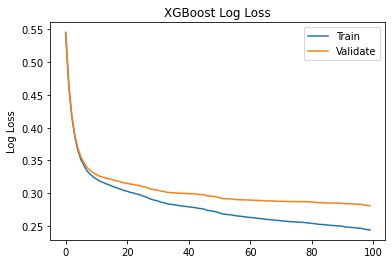

In [165]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validate')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

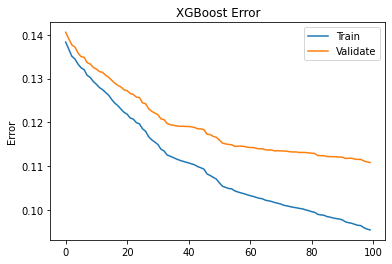

In [166]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validate')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

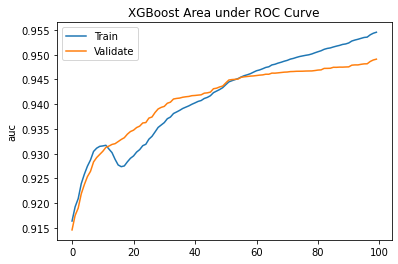

In [167]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validate')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost Area under ROC Curve')
plt.show()

In [191]:
def objective(space):    
        xg_class = xgb.XGBClassifier(n_estimators=100, 
                                  max_depth=space['max_depth'], gamma=space['gamma'],
                                  reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'],
                                  min_child_weight=space['min_child_weight'],
                                  colsample_bytree=space['colsample_bytree'],
                                  subsample=space['subsample'],
                                  learning_rate=space['learning_rate'],
                                  seed=6)    
        eval_set = [(X_use, y_use), (X_validate, y_validate)]
        xg_class.fit(X_use, y_use, eval_set=eval_set, eval_metric='auc',
                early_stopping_rounds=10, verbose=False)
        results = xg_class.evals_result()
        validation_auc_lost = 1.0 - results['validation_1']['auc'][-1]
        return {'loss': validation_auc_lost, 'status': STATUS_OK}

In [192]:
 space={'max_depth': hp.choice("max_depth", np.arange(2, 11, dtype=int)),
           'gamma': hp.uniform('gamma',0.0, 5.0),
           'reg_alpha': hp.uniform('reg_alpha', 0, 1000.0),
           'reg_lambda': hp.uniform('reg_lambda',0, 1000),
           'min_child_weight': hp.uniform('min_child_weight', 0, 120),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
           'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
           'subsample': hp.uniform('subsample', 0.5, 0.95)
          }

In [193]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        return_argmin=False,
                        rstate= np.random.RandomState(2))

100%|██████████| 100/100 [3:37:24<00:00, 130.45s/trial, best loss: 0.05137000000000003] 


In [194]:
best_hyperparams

{'colsample_bytree': 0.5010071816668756,
 'gamma': 1.45859599808764,
 'learning_rate': 0.4990588299107554,
 'max_depth': 10,
 'min_child_weight': 26.990918473393343,
 'reg_alpha': 0.014300489761012614,
 'reg_lambda': 6.788390248524706,
 'subsample': 0.9453061585737766}

### Let's experiment with slowing the learning rate and increasing the number of trees

In [209]:
best_hyperparams['learning_rate'] = 0.1

In [210]:
xg_class = xgb.XGBClassifier(**best_hyperparams, n_jobs=90, n_estimators=1000)

In [211]:
xg_class

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5010071816668756,
              gamma=1.45859599808764, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=10,
              min_child_weight=26.990918473393343, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=90,
              num_parallel_tree=None, random_state=None,
              reg_alpha=0.014300489761012614, reg_lambda=6.788390248524706,
              scale_pos_weight=None, subsample=0.9453061585737766,
              tree_method=None, validate_parameters=None, verbosity=None)

In [212]:
eval_set = [(X_train, y_train)] 
_ = xg_class.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc',
            early_stopping_rounds=10, verbose=True)

[0]	validation_0-auc:0.90485
[1]	validation_0-auc:0.91422
[2]	validation_0-auc:0.91589
[3]	validation_0-auc:0.91875
[4]	validation_0-auc:0.91821
[5]	validation_0-auc:0.91944
[6]	validation_0-auc:0.91773
[7]	validation_0-auc:0.92031
[8]	validation_0-auc:0.92191
[9]	validation_0-auc:0.92254
[10]	validation_0-auc:0.92415
[11]	validation_0-auc:0.92497
[12]	validation_0-auc:0.92590
[13]	validation_0-auc:0.92681
[14]	validation_0-auc:0.92749
[15]	validation_0-auc:0.92861
[16]	validation_0-auc:0.92906
[17]	validation_0-auc:0.92963
[18]	validation_0-auc:0.93035
[19]	validation_0-auc:0.93124
[20]	validation_0-auc:0.93189
[21]	validation_0-auc:0.93202
[22]	validation_0-auc:0.93241
[23]	validation_0-auc:0.93270
[24]	validation_0-auc:0.93319
[25]	validation_0-auc:0.93372
[26]	validation_0-auc:0.93445
[27]	validation_0-auc:0.93475
[28]	validation_0-auc:0.93492
[29]	validation_0-auc:0.93519
[30]	validation_0-auc:0.93551
[31]	validation_0-auc:0.93591
[32]	validation_0-auc:0.93616
[33]	validation_0-au

[268]	validation_0-auc:0.96487
[269]	validation_0-auc:0.96486
[270]	validation_0-auc:0.96489
[271]	validation_0-auc:0.96493
[272]	validation_0-auc:0.96498
[273]	validation_0-auc:0.96502
[274]	validation_0-auc:0.96509
[275]	validation_0-auc:0.96510
[276]	validation_0-auc:0.96515
[277]	validation_0-auc:0.96520
[278]	validation_0-auc:0.96529
[279]	validation_0-auc:0.96537
[280]	validation_0-auc:0.96538
[281]	validation_0-auc:0.96542
[282]	validation_0-auc:0.96542
[283]	validation_0-auc:0.96544
[284]	validation_0-auc:0.96547
[285]	validation_0-auc:0.96548
[286]	validation_0-auc:0.96556
[287]	validation_0-auc:0.96559
[288]	validation_0-auc:0.96561
[289]	validation_0-auc:0.96564
[290]	validation_0-auc:0.96567
[291]	validation_0-auc:0.96572
[292]	validation_0-auc:0.96574
[293]	validation_0-auc:0.96586
[294]	validation_0-auc:0.96593
[295]	validation_0-auc:0.96600
[296]	validation_0-auc:0.96607
[297]	validation_0-auc:0.96612
[298]	validation_0-auc:0.96614
[299]	validation_0-auc:0.96619
[300]	va

[533]	validation_0-auc:0.97373
[534]	validation_0-auc:0.97375
[535]	validation_0-auc:0.97382
[536]	validation_0-auc:0.97383
[537]	validation_0-auc:0.97388
[538]	validation_0-auc:0.97387
[539]	validation_0-auc:0.97389
[540]	validation_0-auc:0.97396
[541]	validation_0-auc:0.97400
[542]	validation_0-auc:0.97399
[543]	validation_0-auc:0.97404
[544]	validation_0-auc:0.97406
[545]	validation_0-auc:0.97407
[546]	validation_0-auc:0.97408
[547]	validation_0-auc:0.97414
[548]	validation_0-auc:0.97414
[549]	validation_0-auc:0.97415
[550]	validation_0-auc:0.97416
[551]	validation_0-auc:0.97421
[552]	validation_0-auc:0.97422
[553]	validation_0-auc:0.97422
[554]	validation_0-auc:0.97426
[555]	validation_0-auc:0.97431
[556]	validation_0-auc:0.97431
[557]	validation_0-auc:0.97433
[558]	validation_0-auc:0.97437
[559]	validation_0-auc:0.97437
[560]	validation_0-auc:0.97440
[561]	validation_0-auc:0.97440
[562]	validation_0-auc:0.97445
[563]	validation_0-auc:0.97447
[564]	validation_0-auc:0.97450
[565]	va

[798]	validation_0-auc:0.97821
[799]	validation_0-auc:0.97822
[800]	validation_0-auc:0.97823
[801]	validation_0-auc:0.97825
[802]	validation_0-auc:0.97825
[803]	validation_0-auc:0.97825
[804]	validation_0-auc:0.97828
[805]	validation_0-auc:0.97827
[806]	validation_0-auc:0.97830
[807]	validation_0-auc:0.97831
[808]	validation_0-auc:0.97832
[809]	validation_0-auc:0.97832
[810]	validation_0-auc:0.97832
[811]	validation_0-auc:0.97836
[812]	validation_0-auc:0.97835
[813]	validation_0-auc:0.97836
[814]	validation_0-auc:0.97837
[815]	validation_0-auc:0.97839
[816]	validation_0-auc:0.97842
[817]	validation_0-auc:0.97841
[818]	validation_0-auc:0.97844
[819]	validation_0-auc:0.97844
[820]	validation_0-auc:0.97844
[821]	validation_0-auc:0.97844
[822]	validation_0-auc:0.97845
[823]	validation_0-auc:0.97843
[824]	validation_0-auc:0.97843
[825]	validation_0-auc:0.97847
[826]	validation_0-auc:0.97847
[827]	validation_0-auc:0.97847
[828]	validation_0-auc:0.97850
[829]	validation_0-auc:0.97853
[830]	va

In [213]:
train_pred = xg_class.predict(X_train)

In [214]:
train_score = xg_class.predict_proba(X_train)

In [219]:
train_score_unpacked = [score[1] for score in train_score]

In [216]:
confusion_matrix(y_train, train_pred)

array([[1300140,  192945],
       [  93301, 1554223]])

In [217]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90   1493085
           1       0.89      0.94      0.92   1647524

    accuracy                           0.91   3140609
   macro avg       0.91      0.91      0.91   3140609
weighted avg       0.91      0.91      0.91   3140609



In [220]:
roc_auc_score(y_train,train_score_unpacked)

0.9689459424033178

In [221]:
test_pred = xg_class.predict(X_test)

In [222]:
test_score = xg_class.predict_proba(X_test)

In [223]:
test_score_unpacked = [score[1] for score in test_score]

In [224]:
confusion_matrix(y_test, test_pred)

array([[141683,  24216],
       [ 12558, 170500]])

In [225]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89    165899
           1       0.88      0.93      0.90    183058

    accuracy                           0.89    348957
   macro avg       0.90      0.89      0.89    348957
weighted avg       0.90      0.89      0.89    348957



In [226]:
roc_auc_score(y_test,test_score_unpacked)

0.9559085631226154

### Now we use the optimized results

In [227]:
best_hyperparams['learning_rate'] = 0.4990588299107554

In [228]:
xg_class = xgb.XGBClassifier(**best_hyperparams, n_jobs=90, n_estimators=100)

In [229]:
xg_class

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5010071816668756,
              gamma=1.45859599808764, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.4990588299107554,
              max_delta_step=None, max_depth=10,
              min_child_weight=26.990918473393343, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=90,
              num_parallel_tree=None, random_state=None,
              reg_alpha=0.014300489761012614, reg_lambda=6.788390248524706,
              scale_pos_weight=None, subsample=0.9453061585737766,
              tree_method=None, validate_parameters=None, verbosity=None)

In [230]:
eval_set = [(X_train, y_train)] 
_ = xg_class.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc',
            early_stopping_rounds=10, verbose=True)

[0]	validation_0-auc:0.90485
[1]	validation_0-auc:0.91554
[2]	validation_0-auc:0.92122
[3]	validation_0-auc:0.92434
[4]	validation_0-auc:0.92581
[5]	validation_0-auc:0.92848
[6]	validation_0-auc:0.93080
[7]	validation_0-auc:0.93320
[8]	validation_0-auc:0.93504
[9]	validation_0-auc:0.93687
[10]	validation_0-auc:0.93801
[11]	validation_0-auc:0.93911
[12]	validation_0-auc:0.94100
[13]	validation_0-auc:0.94156
[14]	validation_0-auc:0.94257
[15]	validation_0-auc:0.94362
[16]	validation_0-auc:0.94444
[17]	validation_0-auc:0.94486
[18]	validation_0-auc:0.94536
[19]	validation_0-auc:0.94586
[20]	validation_0-auc:0.94646
[21]	validation_0-auc:0.94689
[22]	validation_0-auc:0.94772
[23]	validation_0-auc:0.94789
[24]	validation_0-auc:0.94906
[25]	validation_0-auc:0.94954
[26]	validation_0-auc:0.95041
[27]	validation_0-auc:0.95087
[28]	validation_0-auc:0.95104
[29]	validation_0-auc:0.95137
[30]	validation_0-auc:0.95179
[31]	validation_0-auc:0.95200
[32]	validation_0-auc:0.95224
[33]	validation_0-au

In [231]:
train_pred = xg_class.predict(X_train)

In [232]:
train_score = xg_class.predict_proba(X_train)

In [233]:
train_score_unpacked = [score[1] for score in train_score]

In [234]:
confusion_matrix(y_train, train_pred)

array([[1282826,  210259],
       [ 108951, 1538573]])

In [235]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89   1493085
           1       0.88      0.93      0.91   1647524

    accuracy                           0.90   3140609
   macro avg       0.90      0.90      0.90   3140609
weighted avg       0.90      0.90      0.90   3140609



In [236]:
roc_auc_score(y_train,train_score_unpacked)

0.9596537048102349

In [237]:
test_pred = xg_class.predict(X_test)

In [238]:
test_score = xg_class.predict_proba(X_test)

In [239]:
test_score_unpacked = [score[1] for score in test_score]

In [240]:
confusion_matrix(y_test, test_pred)

array([[140633,  25266],
       [ 13768, 169290]])

In [241]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88    165899
           1       0.87      0.92      0.90    183058

    accuracy                           0.89    348957
   macro avg       0.89      0.89      0.89    348957
weighted avg       0.89      0.89      0.89    348957



In [242]:
roc_auc_score(y_test,test_score_unpacked)

0.9497408363350968

### The results with the slower learning rate and more trees performed better on the test set.  Now we re-run tuning by expanding our search space in the areas where we were at the edge: number of trees, subsample, colsample_bytree, and learning rate

In [243]:
 space={'max_depth': hp.choice("max_depth", np.arange(2, 16, dtype=int)),
           'gamma': hp.uniform('gamma',0.0, 5.0),
           'reg_alpha': hp.uniform('reg_alpha', 0, 1000.0),
           'reg_lambda': hp.uniform('reg_lambda',0, 1000),
           'min_child_weight': hp.uniform('min_child_weight', 0, 120),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.95),
           'learning_rate': hp.uniform('learning_rate', 0.1, 0.7),
           'subsample': hp.uniform('subsample', 0.5, 0.99)
          }

In [244]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        return_argmin=False,
                        rstate= np.random.RandomState(2))

100%|██████████| 100/100 [4:47:25<00:00, 172.46s/trial, best loss: 0.05143399999999998] 


In [245]:
best_hyperparams

{'colsample_bytree': 0.7058543733912943,
 'gamma': 1.9859744055042956,
 'learning_rate': 0.4296937662856002,
 'max_depth': 14,
 'min_child_weight': 28.917465521583576,
 'reg_alpha': 1.2534855969648504,
 'reg_lambda': 254.65911235868623,
 'subsample': 0.9356545413090706}

### We now use these tuning parameters to train the model on the entire training set.  We then evaluate the results using the test set.

In [246]:
xg_class = xgb.XGBClassifier(**best_hyperparams, n_jobs=90, n_estimators=100)

In [247]:
xg_class

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.7058543733912943,
              gamma=1.9859744055042956, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.4296937662856002,
              max_delta_step=None, max_depth=14,
              min_child_weight=28.917465521583576, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=90,
              num_parallel_tree=None, random_state=None,
              reg_alpha=1.2534855969648504, reg_lambda=254.65911235868623,
              scale_pos_weight=None, subsample=0.9356545413090706,
              tree_method=None, validate_parameters=None, verbosity=None)

In [248]:
eval_set = [(X_train, y_train)] 
_ = xg_class.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc',
            early_stopping_rounds=10, verbose=True)

[0]	validation_0-auc:0.90207
[1]	validation_0-auc:0.91939
[2]	validation_0-auc:0.92234
[3]	validation_0-auc:0.92613
[4]	validation_0-auc:0.92845
[5]	validation_0-auc:0.92980
[6]	validation_0-auc:0.93120
[7]	validation_0-auc:0.93271
[8]	validation_0-auc:0.93367
[9]	validation_0-auc:0.93491
[10]	validation_0-auc:0.93724
[11]	validation_0-auc:0.93959
[12]	validation_0-auc:0.94213
[13]	validation_0-auc:0.94292
[14]	validation_0-auc:0.94381
[15]	validation_0-auc:0.94396
[16]	validation_0-auc:0.94434
[17]	validation_0-auc:0.94537
[18]	validation_0-auc:0.94608
[19]	validation_0-auc:0.94651
[20]	validation_0-auc:0.94750
[21]	validation_0-auc:0.94781
[22]	validation_0-auc:0.94872
[23]	validation_0-auc:0.94895
[24]	validation_0-auc:0.94940
[25]	validation_0-auc:0.95053
[26]	validation_0-auc:0.95120
[27]	validation_0-auc:0.95163
[28]	validation_0-auc:0.95171
[29]	validation_0-auc:0.95220
[30]	validation_0-auc:0.95263
[31]	validation_0-auc:0.95286
[32]	validation_0-auc:0.95327
[33]	validation_0-au

In [249]:
train_pred = xg_class.predict(X_train)

In [250]:
train_score = xg_class.predict_proba(X_train)

In [251]:
train_score_unpacked = [score[1] for score in train_score]

In [252]:
confusion_matrix(y_train, train_pred)

array([[1276616,  216469],
       [ 110210, 1537314]])

In [253]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89   1493085
           1       0.88      0.93      0.90   1647524

    accuracy                           0.90   3140609
   macro avg       0.90      0.89      0.90   3140609
weighted avg       0.90      0.90      0.90   3140609



In [254]:
roc_auc_score(y_train,train_score_unpacked)

0.957904933465399

In [255]:
test_pred = xg_class.predict(X_test)

In [256]:
test_score = xg_class.predict_proba(X_test)

In [257]:
test_score_unpacked = [score[1] for score in test_score]

In [258]:
confusion_matrix(y_test, test_pred)

array([[140349,  25550],
       [ 13558, 169500]])

In [259]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88    165899
           1       0.87      0.93      0.90    183058

    accuracy                           0.89    348957
   macro avg       0.89      0.89      0.89    348957
weighted avg       0.89      0.89      0.89    348957



In [260]:
roc_auc_score(y_test,test_score_unpacked)

0.9499355639983454

### Now we're going to increase the number of epochs to 500 --- this will hopefully result in a lower learning rate.  

In [261]:
def objective(space):    
        xg_class = xgb.XGBClassifier(n_estimators=500, 
                                  max_depth=space['max_depth'], gamma=space['gamma'],
                                  reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'],
                                  min_child_weight=space['min_child_weight'],
                                  colsample_bytree=space['colsample_bytree'],
                                  subsample=space['subsample'],
                                  learning_rate=space['learning_rate'],
                                  seed=6)    
        eval_set = [(X_use, y_use), (X_validate, y_validate)]
        xg_class.fit(X_use, y_use, eval_set=eval_set, eval_metric='auc',
                early_stopping_rounds=10, verbose=False)
        results = xg_class.evals_result()
        validation_auc_lost = 1.0 - results['validation_1']['auc'][-1]
        return {'loss': validation_auc_lost, 'status': STATUS_OK}

In [262]:
 space={'max_depth': hp.choice("max_depth", np.arange(2, 16, dtype=int)),
           'gamma': hp.uniform('gamma',0.0, 5.0),
           'reg_alpha': hp.uniform('reg_alpha', 0, 1000.0),
           'reg_lambda': hp.uniform('reg_lambda',0, 1000),
           'min_child_weight': hp.uniform('min_child_weight', 0, 120),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.95),
           'learning_rate': hp.uniform('learning_rate', 0.1, 0.7),
           'subsample': hp.uniform('subsample', 0.5, 0.99)
          }

In [263]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        return_argmin=False,
                        rstate= np.random.RandomState(2))

100%|██████████| 100/100 [18:22:36<00:00, 661.57s/trial, best loss: 0.04758499999999999]  


In [264]:
best_hyperparams

{'colsample_bytree': 0.5893303389034698,
 'gamma': 0.0014510211867202472,
 'learning_rate': 0.153066836047544,
 'max_depth': 9,
 'min_child_weight': 4.190530104261271,
 'reg_alpha': 0.014300489761012614,
 'reg_lambda': 11.957028469530997,
 'subsample': 0.8524779791182526}

### We now use these tuning parameters to train the model on the entire training set.  We then evaluate the results using the test set.

In [265]:
xg_class = xgb.XGBClassifier(**best_hyperparams, n_jobs=90, n_estimators=500)

In [266]:
xg_class

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5893303389034698,
              gamma=0.0014510211867202472, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.153066836047544,
              max_delta_step=None, max_depth=9,
              min_child_weight=4.190530104261271, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=90,
              num_parallel_tree=None, random_state=None,
              reg_alpha=0.014300489761012614, reg_lambda=11.957028469530997,
              scale_pos_weight=None, subsample=0.8524779791182526,
              tree_method=None, validate_parameters=None, verbosity=None)

In [267]:
eval_set = [(X_train, y_train)] 
_ = xg_class.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc',
            early_stopping_rounds=10, verbose=True)

[0]	validation_0-auc:0.90104
[1]	validation_0-auc:0.90999
[2]	validation_0-auc:0.91388
[3]	validation_0-auc:0.91645
[4]	validation_0-auc:0.91789
[5]	validation_0-auc:0.91932
[6]	validation_0-auc:0.91934
[7]	validation_0-auc:0.92127
[8]	validation_0-auc:0.92217
[9]	validation_0-auc:0.92332
[10]	validation_0-auc:0.92413
[11]	validation_0-auc:0.92550
[12]	validation_0-auc:0.92661
[13]	validation_0-auc:0.92743
[14]	validation_0-auc:0.92827
[15]	validation_0-auc:0.92910
[16]	validation_0-auc:0.92998
[17]	validation_0-auc:0.93186
[18]	validation_0-auc:0.93272
[19]	validation_0-auc:0.93355
[20]	validation_0-auc:0.93405
[21]	validation_0-auc:0.93451
[22]	validation_0-auc:0.93502
[23]	validation_0-auc:0.93554
[24]	validation_0-auc:0.93600
[25]	validation_0-auc:0.93639
[26]	validation_0-auc:0.93688
[27]	validation_0-auc:0.93714
[28]	validation_0-auc:0.93744
[29]	validation_0-auc:0.93775
[30]	validation_0-auc:0.93822
[31]	validation_0-auc:0.93846
[32]	validation_0-auc:0.93877
[33]	validation_0-au

[268]	validation_0-auc:0.96646
[269]	validation_0-auc:0.96649
[270]	validation_0-auc:0.96658
[271]	validation_0-auc:0.96661
[272]	validation_0-auc:0.96666
[273]	validation_0-auc:0.96673
[274]	validation_0-auc:0.96678
[275]	validation_0-auc:0.96684
[276]	validation_0-auc:0.96687
[277]	validation_0-auc:0.96693
[278]	validation_0-auc:0.96696
[279]	validation_0-auc:0.96701
[280]	validation_0-auc:0.96705
[281]	validation_0-auc:0.96710
[282]	validation_0-auc:0.96714
[283]	validation_0-auc:0.96715
[284]	validation_0-auc:0.96716
[285]	validation_0-auc:0.96718
[286]	validation_0-auc:0.96722
[287]	validation_0-auc:0.96729
[288]	validation_0-auc:0.96731
[289]	validation_0-auc:0.96733
[290]	validation_0-auc:0.96737
[291]	validation_0-auc:0.96749
[292]	validation_0-auc:0.96752
[293]	validation_0-auc:0.96756
[294]	validation_0-auc:0.96761
[295]	validation_0-auc:0.96771
[296]	validation_0-auc:0.96776
[297]	validation_0-auc:0.96779
[298]	validation_0-auc:0.96780
[299]	validation_0-auc:0.96785
[300]	va

In [268]:
train_pred = xg_class.predict(X_train)

In [269]:
train_score = xg_class.predict_proba(X_train)

In [270]:
train_score_unpacked = [score[1] for score in train_score]

In [271]:
confusion_matrix(y_train, train_pred)

array([[1284803,  208282],
       [  95908, 1551616]])

In [272]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89   1493085
           1       0.88      0.94      0.91   1647524

    accuracy                           0.90   3140609
   macro avg       0.91      0.90      0.90   3140609
weighted avg       0.90      0.90      0.90   3140609



In [273]:
roc_auc_score(y_train,train_score_unpacked)

0.9642811750964257

In [274]:
test_pred = xg_class.predict(X_test)

In [275]:
test_score = xg_class.predict_proba(X_test)

In [276]:
test_score_unpacked = [score[1] for score in test_score]

In [277]:
confusion_matrix(y_test, test_pred)

array([[140565,  25334],
       [ 12442, 170616]])

In [278]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88    165899
           1       0.87      0.93      0.90    183058

    accuracy                           0.89    348957
   macro avg       0.89      0.89      0.89    348957
weighted avg       0.89      0.89      0.89    348957



In [279]:
roc_auc_score(y_test,test_score_unpacked)

0.9532070401187402

In [280]:
average_precision_score(y_test, test_score_unpacked, pos_label=1)

0.9545205561861035

Text(0.5, 1.0, 'Precision/Recall Curve, Positive Class is "discount sensitive"')

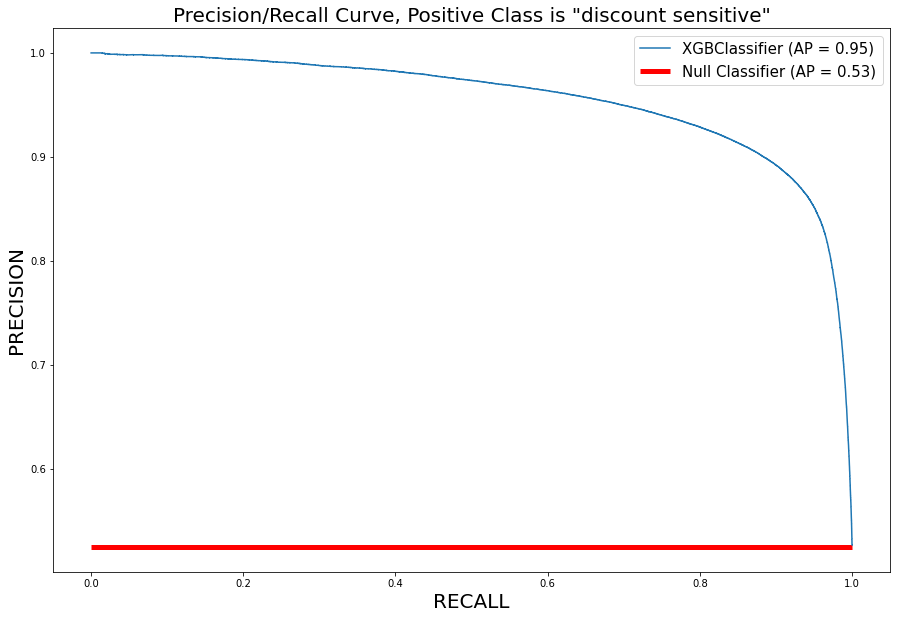

In [349]:
fig = plot_precision_recall_curve(xg_class, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
plt.hlines(0.525, 0.0, 1.0, colors='red', label="Null Classifier (AP = 0.53)", linewidth=5)
plt.xlabel('RECALL', size='20')
plt.ylabel('PRECISION', size='20')
plt.legend(loc='upper right', fontsize=15)
plt.title('Precision/Recall Curve, Positive Class is "discount sensitive"', size='20')

Text(0.5, 1.0, 'ROC Curve, Positive Class is "discount sensitive"')

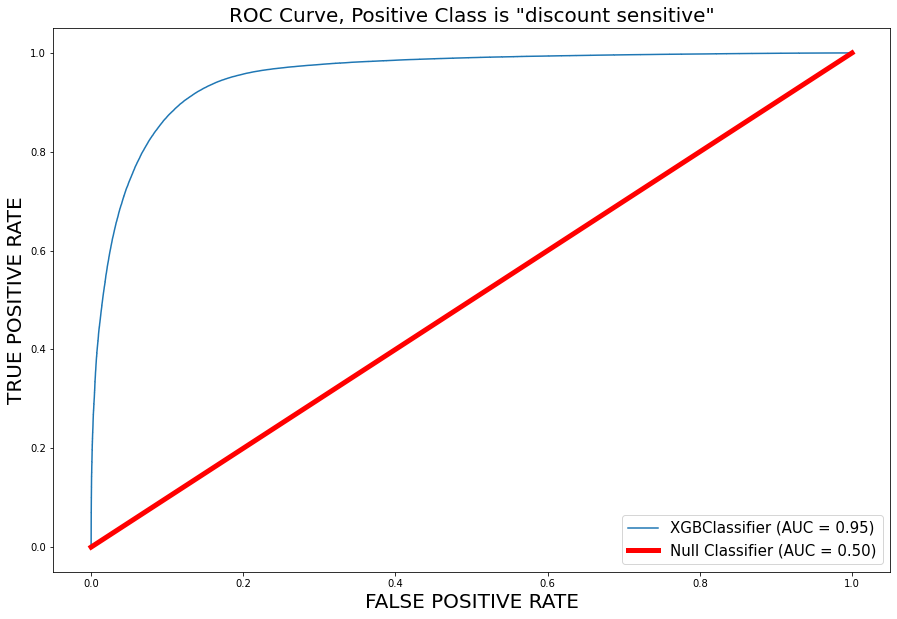

In [347]:
fig = plot_roc_curve(xg_class, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
fig.ax_.plot([0, 1], [0, 1], 'red', linewidth=5, label="Null Classifier (AUC = 0.50)")
plt.xlabel('FALSE POSITIVE RATE', size='20')
plt.ylabel('TRUE POSITIVE RATE', size='20')
plt.legend(loc='lower right', fontsize=15)
plt.title('ROC Curve, Positive Class is "discount sensitive"', size='20')

In [350]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

In [351]:
BUCKET = 'aap-aiexpzone-nonpii-mktg-general-results-prod'
KEY = 'DiscountPreference/Models/XGB/xgb.mod'

In [354]:
write_pickle_to_s3(BUCKET, KEY, xg_class)

In [355]:
model = read_pickle_from_s3(BUCKET, KEY)

In [356]:
type(model)

xgboost.sklearn.XGBClassifier

### Now we process the no_ecomm custmers

In [357]:
len(no_ecomm_table)

18835517

In [397]:
list(no_ecomm_table.columns)

['fyGross',
 'numPurchase',
 'Recency',
 'daysSinceLastPurchase',
 'isEmployee',
 'numReturn',
 'meanPurchaseTransaction',
 'pop_est_cy',
 'pop_density_cy',
 'pct_white',
 'age',
 'pct_college',
 'pct_blue_collar',
 'median_household_income',
 'establishments',
 'IGNITIONEMISSIONFUELSYSTEMS',
 'ADVANCECARESERVICES',
 'AIRFILTERS',
 'LIGHTING',
 'HDHVAC&HYDRAULICS',
 'COMMERCIALHANDSPECIALTYTOOLS',
 'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
 'WINTER&SUMMERSEASONAL',
 'MOTOROIL',
 'HORNSANDSECURITY',
 'COOLINGSYSTEMRADIATORS',
 'GREASE&GEAR',
 'OILFILTERS',
 'APPEARANCECHEMICALS',
 'HDFILTERS',
 'INTERIORACCESSORIES',
 'HDWHEELEND',
 'BRAKESHARDWARE',
 'OIL&GASACCESSORIES',
 'AIRTOOLS&ACCESSORIES',
 'PERFORMANCE&FUNCTIONALCHEMICALS',
 'STORESUPPLIES&FIXTURES',
 'BRAKESHYDRAULICS',
 'HDOTHER',
 'OTHERCORES',
 'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
 'REFERENCE',
 'ENGINEPARTS',
 'TRANSMISSIONFLUID',
 'COMMERCIALBODYREPAIRTOOLS',
 'DRIVELINECLUTCHES',
 'COOLINGSYSTEMPARTS&COMPONENTS',
 'APPEA

### Now we join our new feature dataframes to the no_ecomm table and fill nas

#### First the market code

In [358]:
no_ecomm_table = pd.merge(no_ecomm_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [359]:
no_ecomm_table.isnull().sum()

INDV_ID                                        0
fyGross                                        0
2hGross                                        0
4qGross                                        0
fyNet                                          0
2hNet                                          0
4qNet                                          0
numEcom                                        0
numPurchase                                    0
Recency                                        0
daysSinceLastPurchase                          0
isEmployee                                     0
numReturn                                      0
numCoupon                                      0
LOYALTY_NUMBER                                 0
meanPurchaseTransaction                        0
FULLFILLMENT_STORE_NUMBER                      0
pop_est_cy                                     0
pop_density_cy                                 0
pct_white                                      0
age                 

#### Fill nulls with 0

In [360]:
no_ecomm_table.fillna(0, inplace=True)

#### Now aap store distances

In [361]:
no_ecomm_table = pd.merge(no_ecomm_table, aap_dist, how='left', on='INDV_ID')

In [362]:
no_ecomm_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [363]:
no_ecomm_table['AAP_DIST'] = no_ecomm_table['AAP_DIST'].fillna(no_ecomm_table['AAP_DIST'].mean())

#### Now competitor store distances

In [364]:
no_ecomm_table = pd.merge(no_ecomm_table, comp_dist, how='left', on='INDV_ID')

In [365]:
no_ecomm_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [366]:
no_ecomm_table['CMP_DIST'] = no_ecomm_table['CMP_DIST'].fillna(no_ecomm_table['CMP_DIST'].mean())

In [367]:
no_ecomm_table['aap_closer_by'] = no_ecomm_table['CMP_DIST'] - no_ecomm_table['AAP_DIST']

In [368]:
no_ecomm_table['comp_dist_ratio'] = no_ecomm_table['CMP_DIST']/no_ecomm_table['AAP_DIST']

### Now let's get the customer lifetime (tenure)

In [370]:
no_ecomm_table = pd.merge(no_ecomm_table, tenure, how='left', on='INDV_ID')

In [371]:
no_ecomm_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [372]:
no_ecomm_table.loc[(no_ecomm_table.TENURE < 1), 'TENURE'] = 1

In [373]:
features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'TOTAL',
     'Sends',
     'Revenue',
     'OpenRate',
     'ClickRate',
     'ConversionRate',
     'numSessions',
     'meanHits',
     'meanPages',
     'meanRemovals',
     'meanPurchases',
     'meanAdditions',
     'meanCheckouts',
     'meanAbandoned',
     'meanQuality',
     'meanTime',
     'acura',
     'audi',
     'bmw',
     'bick',
     'cadillac',
     'chevrolet',
     'chrysler',
     'dodge',
     'ford',
     'gmc',
     'harleydavidson',
     'honda',
     'hyundai',
     'infiniti',
     'isuzu',
     'jaguar',
     'jeep',
     'kia',
     'landrover',
     'lexus',
     'lincoln',
     'mazda',
     'mercedesbenz',
     'mercury',
     'mini',
     'mitsubishi',
     'nissan',
     'oldsmobile',
     'plymouth',
     'pontiac',
     'ram',
     'saab',
     'saturn',
     'scion',
     'subaru',
     'suzuki',
     'toyota',
     'volkswagen',
     'volvo',
     'yamaha',
     'maxVehicleAge',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [374]:
label = ['3quarter']

In [375]:
no_ecomm_table = no_ecomm_table[features + label]

### Now we evaluate the class balance

In [376]:
summary = no_ecomm_table.groupby(label)['TENURE'].count().reset_index()

In [377]:
summary['FRACTION'] = summary['TENURE']/summary['TENURE'].sum()

In [378]:
summary

3quarter    TENURE             FRACTION
0         0  17720955                0.941
1         1   1114564                0.059

### We one-hot encode market class

In [379]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto', dtype=np.int, handle_unknown='ignore')

In [381]:
market_class_feature = onehot_encoder.fit_transform(no_ecomm_table[['MARKET_CLASS_CODE']])


In [382]:
market_class_feature.shape

(18835519, 8)

In [383]:
market_categories = [cat for cat in onehot_encoder.categories_[0]]

In [384]:
market_categories

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [385]:
market_categories_dict = {0: 'zero', 
                             1: 'one',
                             2: 'two',
                             3: 'three',
                             4: 'four',
                             5: 'five',
                             6: 'six',
                             7: 'seven'}

In [386]:
market_categories = list(map(market_categories_dict.get, market_categories))

In [387]:
market_class_dataframe = pd.DataFrame(market_class_feature)
market_class_dataframe.columns = market_categories

In [388]:
market_class_dataframe.head()

zero  one  two  three  four  five  six  seven
0     0    0    0      0     0     0    1      0
1     0    0    0      0     0     0    1      0
2     0    0    0      0     0     0    1      0
3     0    0    0      0     0     1    0      0
4     0    0    0      0     0     0    1      0

In [389]:
no_ecomm_table.reset_index(drop=True, inplace=True)

In [390]:
len(no_ecomm_table), len(market_class_dataframe)

(18835519, 18835519)

In [391]:
no_ecomm_table = pd.merge(no_ecomm_table, market_class_dataframe, left_index=True, right_index=True)

In [392]:
no_ecomm_table[market_categories + ['MARKET_CLASS_CODE']].head(20)

zero  one  two  three  four  five  six  seven    MARKET_CLASS_CODE
0      0    0    0      0     0     0    1      0                6.000
1      0    0    0      0     0     0    1      0                6.000
2      0    0    0      0     0     0    1      0                6.000
3      0    0    0      0     0     1    0      0                5.000
4      0    0    0      0     0     0    1      0                6.000
5      0    0    0      0     0     0    1      0                6.000
6      0    0    0      0     0     0    1      0                6.000
7      0    0    0      0     0     0    1      0                6.000
8      0    0    0      0     0     0    1      0                6.000
9      0    0    0      0     0     1    0      0                5.000
10     0    0    0      0     0     0    1      0                6.000
11     0    0    0      0     0     0    1      0                6.000
12     0    0    0      0     0     0    1      0                6.000
13     0    0    0      0     0     0    1      0                6.000
14     0    0    0      0     0     0    1      0                6.000
15     0    0    0      0     0     0    0      1                7.000
16     0    0    0      0     0     0    1      0                6.000
17     0    0    0      0     1     0    0      0                4.000
18     0    0    0      0     0     0    1      0                6.000
19     0    0    0      0     0     1    0      0                5.000

In [393]:
no_ecomm_table.drop(columns={'MARKET_CLASS_CODE'}, inplace=True)

In [394]:
features = [feature for feature in features if feature != 'MARKET_CLASS_CODE']

### Now we split the no_ecomm table into train and test

In [423]:
X_train, X_test, y_train, y_test = train_test_split(no_ecomm_table[features], no_ecomm_table[label], 
                                                    test_size=0.5, random_state=1, stratify=no_ecomm_table[label])

MemoryError: Unable to allocate 6.17 GiB for an array with shape (44, 18835519) and data type int64

### We lock up the test (holdout) set in a vault, and split the training set into use and validate.  We will use the validation set for tuning

In [422]:
X_use, X_validate, y_use, y_validate = train_test_split(X_train, y_train, 
                                                    test_size=0.5, random_state=1, stratify=y_train)

### Now we're going to increase the number of epochs to 500 --- this will hopefully result in a lower learning rate.  

In [410]:
def objective(space):    
        xg_class = xgb.XGBClassifier(n_estimators=10, 
                                  max_depth=space['max_depth'], gamma=space['gamma'],
                                  reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'],
                                  min_child_weight=space['min_child_weight'],
                                  colsample_bytree=space['colsample_bytree'],
                                  subsample=space['subsample'],
                                  learning_rate=space['learning_rate'],
                                  seed=6)    
        eval_set = [(X_use, y_use), (X_validate, y_validate)]
        xg_class.fit(X_use, y_use, eval_set=eval_set, eval_metric='auc',
                early_stopping_rounds=10, verbose=False)
        results = xg_class.evals_result()
        validation_auc_lost = 1.0 - results['validation_1']['auc'][-1]
        return {'loss': validation_auc_lost, 'status': STATUS_OK}

In [413]:
 space={'max_depth': hp.choice("max_depth", np.arange(2, 16, dtype=int)),
           'gamma': hp.uniform('gamma',0.0, 5.0),
           'reg_alpha': hp.uniform('reg_alpha', 0, 1000.0),
           'reg_lambda': hp.uniform('reg_lambda',0, 1000),
           'min_child_weight': hp.uniform('min_child_weight', 0, 120),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.95),
           'learning_rate': hp.uniform('learning_rate', 0.1, 0.7),
           'subsample': hp.uniform('subsample', 0.2, 0.3)
          }

In [414]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials,
                        return_argmin=False,
                        rstate= np.random.RandomState(2))

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: Unable to allocate 19.7 GiB for an array with shape (173, 15256770) and data type float64



  0%|          | 0/10 [00:01<?, ?trial/s, best loss=?]


MemoryError: Unable to allocate 19.7 GiB for an array with shape (173, 15256770) and data type float64

In [418]:
best_hyperparams['subsample'] = 0.1

In [419]:
xg_class = xgb.XGBClassifier(**best_hyperparams, n_jobs=90, n_estimators=10)

In [420]:
xg_class

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5893303389034698,
              gamma=0.0014510211867202472, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.153066836047544,
              max_delta_step=None, max_depth=9,
              min_child_weight=4.190530104261271, missing=nan,
              monotone_constraints=None, n_estimators=10, n_jobs=90,
              num_parallel_tree=None, random_state=None,
              reg_alpha=0.014300489761012614, reg_lambda=11.957028469530997,
              scale_pos_weight=None, subsample=0.1, tree_method=None,
              validate_parameters=None, verbosity=None)

In [421]:
eval_set = [(X_train, y_train)] 
_ = xg_class.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc',
            early_stopping_rounds=10, verbose=True)

MemoryError: Unable to allocate 21.9 GiB for an array with shape (173, 16951967) and data type float64